In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb

In [2]:
files = ['FS1', 'PS2', 'profile']
df_dict = {}
for f in files:
    df_dict[f] = pd.read_csv(f'data/{f}.txt', sep='\t', header=None)
    print(f'{f} got Nan values : {df_dict[f].isnull().values.any()}')
    print(f'{f} : {df_dict[f].shape}')

FS1 got Nan values : False
FS1 : (2205, 600)
PS2 got Nan values : False
PS2 : (2205, 6000)
profile got Nan values : False
profile : (2205, 5)


In [3]:
df_dict['valve_condition'] = df_dict['profile'].iloc[:,[1]].reset_index(drop=True)
df_dict['valve_condition'].columns = ['y0']
df_dict['valve_condition']['y1'] = (df_dict['valve_condition']['y0'] != 100).astype(int)
del df_dict['profile']

On initiliase les variables cibles:  
100% : 0  
!= 100% : 1  
Je décide  d'initialiser de cette manière car ce sont les cycles de productions qui ne sont pas optimaux qui peuvent potentiellement couter à l'entreprise que l'ont veut prédire.
Initiliaser les classes de cette manière permet de jouer plus facilement avec le modèle pour un meilleur ajustement entre precision et recall (dans un secteur industriel un bon 
recall sera peut être plus intéressant car une panne non detectée peut avoir des couts importants).

In [4]:
df_dict['valve_condition']['y1'].value_counts(normalize=True)*100

y1
0    51.020408
1    48.979592
Name: proportion, dtype: float64

-> classes équilibrées

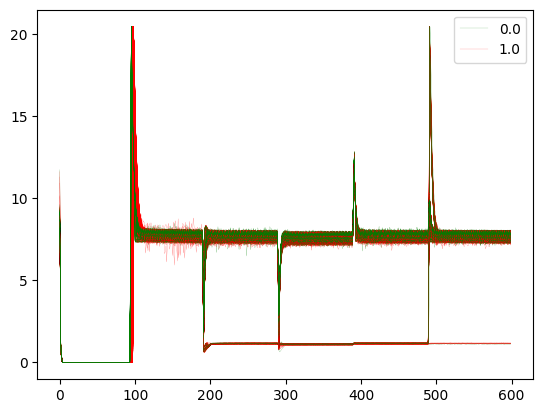

In [5]:
# On compare visuellement l'allure des cycles (vert: cycle optimal, rouge: non optimal)
df_temp = pd.concat([df_dict['FS1'], df_dict['valve_condition']], axis=1)
# iterate through the rows and plot
for i, v in df_temp.iterrows():
    # get the values and labels to plot
    y1 = v[:-2]
    label = v['y1']
    if label == 1:
        c = 'r'
    else:
        c = 'g'
    plt.plot(y1, label=label, color=c, linewidth=0.1)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

/home/tdelatte/miniconda3/envs/dataswati/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


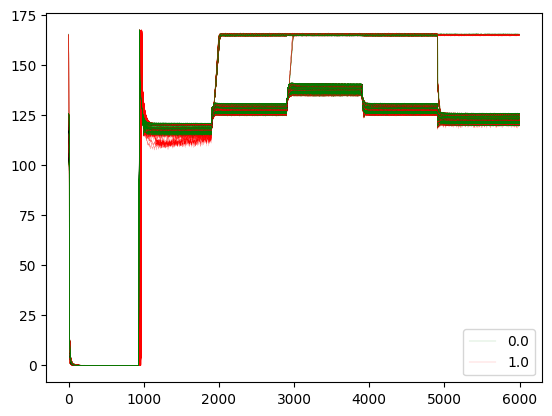

In [7]:
df_temp = pd.concat([df_dict['PS2'], df_dict['valve_condition']], axis=1)
# iterate through the rows and plot
for i, v in df_temp.iterrows():
    # get the values and labels to plot
    y1 = v[:-2]
    label = v['y1']
    if label == 1:
        c = 'r'
    else:
        c = 'g'
    plt.plot(y1, label=label, color=c, linewidth=0.1)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

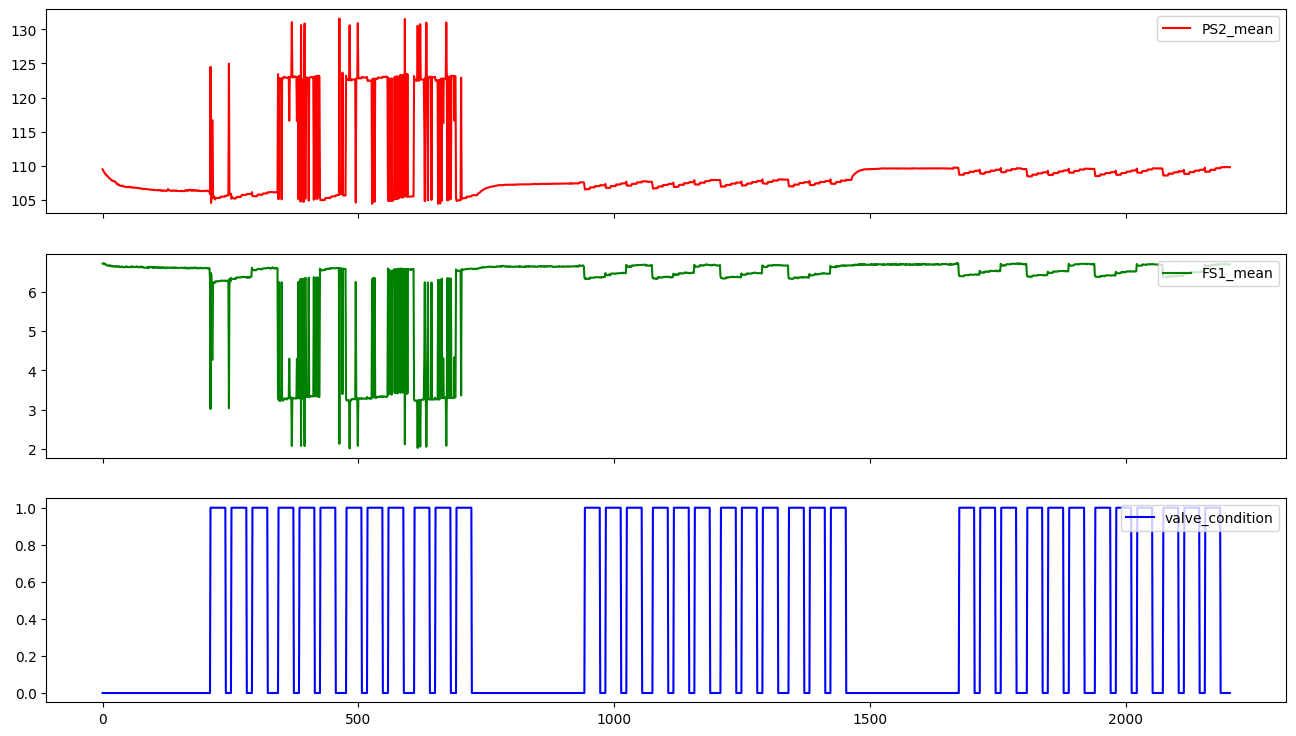

In [8]:
df_dict['PS2_mean'] = pd.DataFrame(df_dict['PS2'].mean(axis=1), columns=['mean_ps2'])
df_dict['FS1_mean'] = pd.DataFrame(df_dict['FS1'].mean(axis=1), columns=['mean_fs1'])
fig, ax = plt.subplots(figsize=(16,9), nrows=3, ncols=1, sharex=True)
colors = 'rgb'
for i, df in enumerate(['PS2_mean', 'FS1_mean', 'valve_condition']):
    if df == 'valve_condition':
        ax[i].plot(df_dict[df]['y1'], color=colors[i], label=df)
        ax[i].legend(loc="upper right")
    else: 
        ax[i].plot(df_dict[df], color=colors[i], label=df)
        ax[i].legend(loc="upper right")

In [9]:
df_temp = pd.concat([df_dict['PS2_mean'], df_dict['FS1_mean'], df_dict['valve_condition']], axis=1)
# display(corr.style.background_gradient(cmap='coolwarm'))
# display(df_temp.corr().style.background_gradient(cmap='coolwarm', axis=None))
# sb.heatmap(df_temp.corr(numeric_only=True), cmap="YlGnBu", annot=True)

<Axes: xlabel='mean_ps2', ylabel='mean_fs1'>

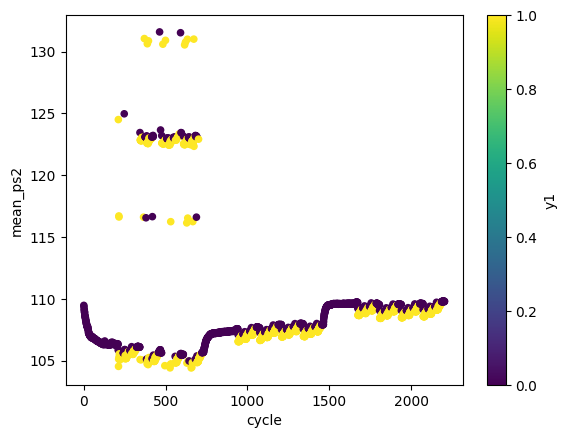

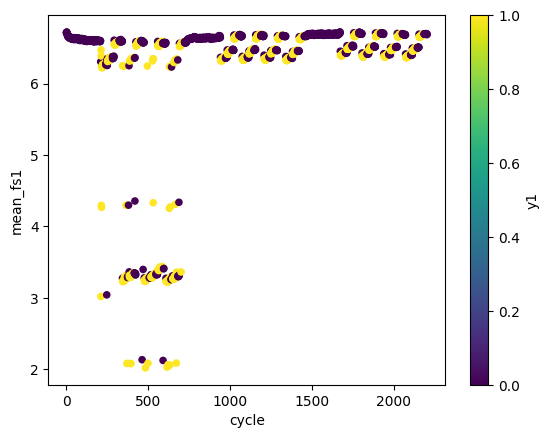

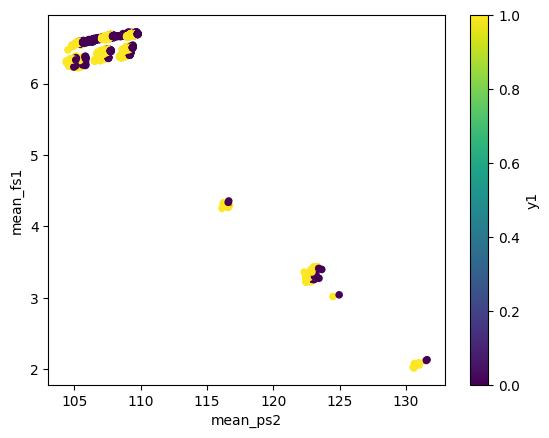

In [10]:
df_temp.reset_index().plot.scatter(x='index', y='mean_ps2', c='y1', colormap='viridis', xlabel='cycle')
df_temp.reset_index().plot.scatter(x='index', y='mean_fs1', c='y1', colormap='viridis', xlabel='cycle')
df_temp.plot.scatter(x='mean_ps2', y='mean_fs1', c='y1', colormap='viridis')

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

models = []

models.append(("LogisticRegression",LogisticRegression(random_state=42)))
models.append(("LinearSVC",LinearSVC(random_state=42)))
models.append(("KNeighbors",KNeighborsClassifier()))
models.append(("DecisionTree",DecisionTreeClassifier(random_state=42)))
models.append(("RandomForest",RandomForestClassifier(random_state=42)))

X = df_temp[['mean_ps2', 'mean_fs1']]
y = df_temp['y1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

results = []
names = []
for name, model in models:
    result = cross_val_score(model, X_train, y_train,  cv=5)
    names.append(name)
    results.append(result)

for i in range(len(names)):
    print(names[i],results[i].mean())

LogisticRegression 0.6562259878380785
LinearSVC 0.611378266290105
KNeighbors 0.921864743149378
DecisionTree 0.8861028420222375
RandomForest 0.9072564435284839


  La méthode KNN ressort comme étant un des modèles les plus performants ici.
Il faut désormais trouver les meilleurs hyperparamètres pour essayer de gagner un meilleur. (il pourrait être intéressant de se pencher également sur le RandomForest)  

In [13]:
# On recherche la meilleure paramètrisation de KNN à l'aide de GridSearch :
k_n = [2, 5, 20, 30, 50]
weights = ["uniform", "distance"]
leaf_size=[5, 10, 20]
p=[1,2,3,4,5] 
algorithm=['auto', 'ball_tree', 'kd_tree', 'brute']

param_grid = dict(n_neighbors = k_n, weights = weights, algorithm= algorithm ,leaf_size = leaf_size , p =p)

knn = KNeighborsClassifier()

grid_model = GridSearchCV(knn, param_grid, cv = 5, scoring = 'recall')

grid_model.fit(X_train,y_train)
print(grid_model.best_params_)

{'algorithm': 'auto', 'leaf_size': 5, 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}


In [15]:
ml_model = KNeighborsClassifier(algorithm= 'auto', leaf_size= 5, n_neighbors= 5, p= 1, weights= 'uniform')
ml_model.fit(X_train,y_train)
predictions = ml_model.predict(X_test)

print("Accuracy :",accuracy_score(y_test,predictions), "\nRecall :",recall_score(y_test,predictions))

Accuracy : 0.9276018099547512 
Recall : 0.9203539823008849


En se basant simplement sur les moyennes des cycles de PS2 et FS1, on arrive à monter un modèle avec une accuracy de 92.7%.

D'après l'énoncé présentant les données on peut se permettre de considérer les cycles comme continus.
On peut alors envisager des méthodes de séries temporelles, commes le LSTM ou lissage exponentiel.

In [18]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

ps2 = df_dict['PS2'].to_numpy()[:,::10]
ps2 = ps2.flatten()
ps2.shape

fs1 = df_dict['FS1'].to_numpy()
fs1 = fs1.flatten()
fs1.shape

data_x = np.vstack((ps2, fs1)).T
data_y = df_dict['valve_condition']['y1']
def create_dataset(dataset, window):
    X, y = [], []
    for i in range(int((len(dataset)/600)-window)):
        feature = dataset[i*600:(i+window)*600]
        target = data_y[i+window]
        X.append(feature)
        y.append(target)
    return X, y

X, y = create_dataset(data_x,2)
X_train, X_test = X[0:2000], X[2000:len(X)]
y_train, y_test = y[0:2000], y[2000:len(X)]

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        # Define the layers
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True, dropout=0.5, num_layers=1)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True, dropout=0.5, num_layers=1)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Pass through the first LSTM layer
        lstm_out, _ = self.lstm1(x)
        # Pass through the second LSTM layer (take the output of the last time step)
        lstm_out, _ = self.lstm2(lstm_out)
        lstm_out = lstm_out[:, -1, :]  # Taking the last output for classification
        # Pass through the fully connected layer
        out = self.fc(lstm_out)
        return self.sigmoid(out)

# Define function to train the model
def train_model(model, train_loader, criterion, optimizer, num_epochs, device, patience):
    model.to(device)  # Move model to GPU if available
    model.train()
    top_epoch_acc = 0
    trials = 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate running loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        
        if epoch_acc > top_epoch_acc:
            trials = 0
            top_epoch_acc = epoch_acc
            # J'ai eu des soucis avec la sauvegarde de modele avec torch qui n'a jamais fonctionné.
            # torch.save(model.state_dict(), 'best.pth')
            best_model = model
            print(f'Epoch {epoch} best model saved with accuracy: {top_epoch_acc:2.2%}')
        else:
            trials += 1
            print(f'patience: {trials/patience}')
            if trials >= patience:
                print(f'Early stopping on epoch {epoch}')
                break
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
    return best_model

# Data preparation (assuming x and y are numpy arrays)
def prepare_data(x, y, batch_size):
    x_tensor = torch.tensor(x, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # Reshape labels to match output shape
    dataset = TensorDataset(x_tensor, y_tensor)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return train_loader

In [19]:
input_size = 2
hidden_size = 64
output_size = 1
num_epochs = 20
batch_size = 32
learning_rate = 0.001
patience = 5

# Initialize model, criterion, and optimizer
model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.BCELoss()  # Binary cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Prepare data loader
train_loader = prepare_data(X_train, y_train, batch_size)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Train the model
model = train_model(model, train_loader, criterion, optimizer, num_epochs, device, patience)

Epoch 0 best model saved with accuracy: 46.10%
Epoch [1/20], Loss: 0.7133, Accuracy: 0.4610
Epoch 1 best model saved with accuracy: 52.70%
Epoch [2/20], Loss: 0.6937, Accuracy: 0.5270
Epoch 2 best model saved with accuracy: 68.15%
Epoch [3/20], Loss: 0.6496, Accuracy: 0.6815
Epoch 3 best model saved with accuracy: 82.75%
Epoch [4/20], Loss: 0.4948, Accuracy: 0.8275
Epoch 4 best model saved with accuracy: 92.55%
Epoch [5/20], Loss: 0.2588, Accuracy: 0.9255
Epoch 5 best model saved with accuracy: 94.25%
Epoch [6/20], Loss: 0.2169, Accuracy: 0.9425
Epoch 6 best model saved with accuracy: 94.85%
Epoch [7/20], Loss: 0.1955, Accuracy: 0.9485
Epoch 7 best model saved with accuracy: 96.10%
Epoch [8/20], Loss: 0.1628, Accuracy: 0.9610
patience: 0.2
Epoch [9/20], Loss: 0.1685, Accuracy: 0.9590
Epoch 9 best model saved with accuracy: 96.35%
Epoch [10/20], Loss: 0.1555, Accuracy: 0.9635
Epoch 10 best model saved with accuracy: 96.40%
Epoch [11/20], Loss: 0.1535, Accuracy: 0.9640
patience: 0.2
Epoc

In [21]:
    
# Function to test the model
def test_model(model, test_loader, criterion, device):
    model.to(device)
    model.eval()  # Set the model to evaluation mode (disable dropout)

    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # No gradient calculation during testing
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = running_loss / len(test_loader.dataset)
    test_acc = correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')
    #print(labels, outputs)
    
test_loader = prepare_data(X_test, y_test, batch_size)
# Test the model
test_model(model, test_loader, criterion, device)

Test Loss: 0.1792, Test Accuracy: 0.9557


On obtient un Long Short Term Memory avec une accuracy de 95% (je n'ai pas pu sauvegarder le modèle avec torch)